In [22]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle
# utilities
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', 
          '#A2C8EC', '#FFBC79', '#CFCFCF']
bands = ['lightgrey', 'mistyrose', 'peachpuff', 'moccasin', 'khaki',
         'palegreen', 'lightcyan', 'powderblue', 'mediumspringgreen', 'lavender',
        'thistle', 'lavenderblush', 'gainsboro']
markers = ["p","v","X","o","s",
           "P","^","d","<",
           "3","*",">"]
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Solving inner optimization problem

This code block contains the numerical methods for the inner optimization defined in the RMDP formulation. We consider the total variation uncertainty set. We solve the optimization problem through its dual reformulation.

In [23]:
from scipy.optimize import minimize

def worstcase_L1(V, Po, gamma, rho):
    """
    Computes the solution of:
    min_P          P dot V
    subject to     || P - Po ||_L1 <= rho
    via its dual formulation.
    """
    if rho == 0:
        return np.dot(V, Po)
    if rho < 0:
        raise ValueError("Uncertainty parameter rho must be at least 0.")
    if Po.dtype != float:
        raise ValueError("Value function V must be a float array.")
    if not 0.99 <= np.sum(Po) <= 1.0:
        raise ValueError("Po should be a probability vector.")
        
    def dual_L1(eta):
        """Dual formulation for L1 divergence. See (Panaganti et al., 2022, Lemma 5)"""
        ones = np.ones_like(V)
        res = np.dot(Po, np.maximum(eta * ones - V, 0)) + np.max(eta - np.min(V), 0) * rho - eta
        return res
    
    bounds = [(0.0, 2/(rho*(1-gamma)))]
    res = minimize(dual_L1, x0=0, method='SLSQP', bounds=bounds, tol=1e-3)

    return max(-res.fun, 0)

import cvxpy as cp

def worstcase_L1_primal(V, Po, rho):
    """
    Computes the solution of:
    min_P          P dot V
    subject to     || P - Po ||_L1 <= rho
    via its primal problem.
    """
    if rho == 0:
        return np.dot(V, Po)
    if rho < 0:
        raise ValueError("Uncertainty parameter rho must be at least 0.")
    if Po.dtype != float:
        raise ValueError("Value function V must be a float array.")
    if not 0.99 <= np.sum(Po) <= 1.0:
        raise ValueError("Po should be a probability vector.")

    nS = len(V)
    
    # Construct the problem
    P = cp.Variable(nS)
    objective = cp.Minimize(V @ P)
    constraints = [cp.norm(P-Po,1) <= rho]
    constraints += [cp.sum(P) == 1]
    constraints += [P >= 0]
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve()

    return result

#### Generate offline data

We implement two kinds of offline data: global coverage and partial coverage. For the former, the dataset is generated by a generative model. In this way, the uniform concentrability

$$ C_u = \sup_\pi \sup_{(s,a)\in \mathcal{S}\times\mathcal{A}} \frac{d^\pi(s,a)}{\mu(s,a)}$$

is bounded. For the partial coverage, we use the following data-generating distribution

$$ \mu(a | s) = \frac{\mathbf{1}_{\{a=\pi^*(s)\}}}{2} + \frac{\mathbf{1}_{\{ a = \mathrm{unif}(\mathcal{A})\}}}{2}.$$

It is clear that this data-generating distribution covers the state-action visitation distribution of the optimal policy $\pi^*$.

In [24]:
# Generative model
# Every (s,a) gets N_samples number of next-state samples
def construct_full_coverage_model(env, N_sample=100):
    nS = env.nrow * env.ncol
    nA = len(env.P[0])
    N_sample_sa = int(N_sample / (nS * nA))
    if not N_sample_sa > 0:
        raise Exception("Total number of data should be at least |S||A|!")
    P_emp = {s : {a : {ns : 0 for ns in range(nS)} for a in range(nA)} for s in range(nS)}
    N_sa = {s : {a : N_sample_sa for a in range(nA)} for s in range(nS)}
    N_sans = {s : {a : {ns : 0 for ns in range(nS)} for a in range(nA)} for s in range(nS)}
    for s in range(nS):
        for a in range(nA):
            ns_ls = []
            prob_sa = []
            for (p,n,r,t) in env.P[s][a]:
                ns_ls.append(n)
                prob_sa.append(p)
            for i in range(N_sample_sa):
                ns_data = np.random.choice(ns_ls,p=prob_sa)
                N_sans[s][a][ns_data] += 1
            for ns in range(nS):
                P_emp[s][a][ns] = N_sans[s][a][ns] / N_sa[s][a]
    return P_emp, N_sa, N_sans

# Partial coverage
# Every s gets N_sample * nA number of samples
def construct_partial_coverage_model(env, pistar, N_sample=100):
    nS = env.nrow * env.ncol
    nA = len(env.P[0])
    P_emp = {s : {a : {ns : 0 for ns in range(nS)} for a in range(nA)} for s in range(nS)}
    N_sans = {s : {a : {ns : 0 for ns in range(nS)} for a in range(nA)} for s in range(nS)}
    N_sa = {s : {a : 0 for a in range(nA)} for s in range(nS)}
    count = 0
    while count < N_sample:
        s, _ = env.reset(seed=random.randint(0,100))
        done = False
        while not done:
            a_probs = np.zeros(nA) + 1/(nA * 2)
            a_probs[int(pistar[s])] += 1/2  # increase the chance for picking the optimal action
            a = np.random.choice(nA, p=a_probs)  # choose action according to mu
            ns, r, done, _, _= env.step(a)
            # Record
            N_sans[s][a][ns] += 1
            N_sa[s][a] += 1
            # Iterate
            s = ns
            count += 1
            if count >= N_sample:
                break
    # Processing  
    for s in range(nS):
        for a in range(nA):
            for ns in range(nS):
                if N_sa[s][a] == 0:
                    P_emp[s][a][ns] = 1/nS
                else:
                    P_emp[s][a][ns] = N_sans[s][a][ns] / N_sa[s][a]   
    return P_emp, N_sa, N_sans

# Determine the pessimism needed based on a data (TV)
def construct_rho_matrix_TV(env, delta, N_sa):
    nS = env.nrow * env.ncol
    nA = len(env.P[0])
    rho_mtx = np.zeros((nS,nA))
    for s in range(nS):
        for a in range(nA):
            if N_sa[s][a] == 0:
                rho_mtx[s][a] = 1 # no coverage needs more pessimism
            else:
                rho_mtx[s][a] = min(1, np.sqrt( max(nS, 2*np.log(2*nS*nA/delta)) / N_sa[s][a]))
    return rho_mtx 

#### Algorithms

This section contains the implementation of VI, empirical VI, and robust empirical VI.

In [25]:
# Value Iteration - produce pi*
def value_iteration(env, gamma, r_mtx, t_mtx, P, target_convergence=0.001):
    nS = env.nrow * env.ncol
    nA = len(env.P[0])
    # Initialize value function and pi
    V_0 = np.ones(nS)
    value_func_list = [V_0]
    pi = np.zeros(nS)  # directly record pi
    # Utility
    convergence_list = []
    itr_count = 0
    # iteration
    converged = False
    while (not converged):
        itr_count += 1
        curr_value_func = np.zeros(nS)
        last_value_func = value_func_list[-1]
        for s in range(nS):
            curr_max_q = -1
            for a in range(nA):
                q_sa = r_mtx[s][a]
                if t_mtx[s][a] != 1:  # only have discounted future reward if not terminal
                    for ns in range(nS):
                        q_sa += gamma * P[s][a][ns] * last_value_func[ns]
                if q_sa > curr_max_q:
                    curr_max_q = q_sa
                    pi[s] = a
            curr_value_func[s] = curr_max_q
        value_func_list.append(curr_value_func) # store value function of current iteration
        curr_convergence = np.linalg.norm(curr_value_func - last_value_func) # calc current convergence
        convergence_list.append(curr_convergence) # store current convergence
        if curr_convergence < target_convergence: # check if we can stop
            converged = True

    return pi, np.round(value_func_list[-1], 3)

# Empirical value iteration
def empirical_value_iteration(env, gamma, r_mtx, t_mtx, model, target_convergence=0.001):
    nS = env.nrow * env.ncol
    nA = len(env.P[0])
    # Initialize value function and pi
    V_0 = np.ones(nS)
    value_func_list = [V_0]
    pi = np.zeros(nS)  # directly record pi
    # Utility
    convergence_list = []
    itr_count = 0
    # iteration
    converged = False
    while (not converged):
        itr_count += 1
        curr_value_func = np.zeros(nS)
        last_value_func = value_func_list[-1]
        for s in range(nS):
            curr_max_q = -1
            for a in range(nA):
                q_sa = r_mtx[s][a]
                if t_mtx[s][a] != 1:  # only have discounted future reward if not terminal
                    for ns in range(nS):
                        q_sa += gamma * model[s][a][ns] * last_value_func[ns]
                if q_sa > curr_max_q:
                    curr_max_q = q_sa
                    pi[s] = a
            curr_value_func[s] = curr_max_q
        value_func_list.append(curr_value_func) # store value function of current iteration
        curr_convergence = np.linalg.norm(curr_value_func - last_value_func) # calc current convergence
        convergence_list.append(curr_convergence) # store current convergence
        if curr_convergence < target_convergence: # check if we can stop
            converged = True

    return pi, np.round(value_func_list[-1], 3)
    
# # Empirical robust value iteration
def empirical_robust_value_iteration(env, gamma, r_mtx, t_mtx, model, rho_mtx, target_convergence=0.001):
    nS = env.nrow * env.ncol 
    nA = len(env.P[0])
    # Initialize value function and pi
    V_0 = np.zeros(nS)
    value_func_list = [V_0]
    pi = np.zeros(nS)  # directly record pi
    # Utility
    convergence_list = []
    itr_count = 0

    # iteration
    converged = False
    while (not converged):
        itr_count += 1
        curr_value_func = np.zeros(nS)
        last_value_func = value_func_list[-1]
        for s in range(nS):
            curr_max_q = -1
            for a in range(nA):
                q_sa = r_mtx[s][a]
                if t_mtx[s][a] != 1:  # only have discounted future reward if not terminal
                    prob_sa = np.fromiter(model[s][a].values(), dtype=float)
                    # q_sa += gamma * worstcase_L1(last_value_func , prob_sa, gamma, rho_mtx[s][a])
                    q_sa += gamma * worstcase_L1_primal(last_value_func , prob_sa, rho_mtx[s][a])
                
                if q_sa > curr_max_q:
                    curr_max_q = q_sa
                    pi[s] = a
            curr_value_func[s] = curr_max_q
        value_func_list.append(curr_value_func) # store value function of current iteration
        curr_convergence = np.linalg.norm(curr_value_func - last_value_func) # calc current convergence
        convergence_list.append(curr_convergence) # store current convergence
        if curr_convergence < target_convergence: # check if we can stop
            converged = True

    return pi, np.round(value_func_list[-1], 3)

# VI-LCB algorithm
def VI_LCB(env, gamma, delta, r_mtx, t_mtx, model, N, N_sa, cb, target_convergence=0.001):
    nS = env.nrow * env.ncol
    nA = len(env.P[0])
    # Some VI-LCB constants
    T = np.log(N)/(1-gamma)
    L = cb * np.log(2*(T+1)*nS*nA/delta)
    # Initialize value function and pi
    V_0 = np.ones(nS)
    value_func_list = [V_0]
    pi = np.zeros(nS)  # directly record pi
    # Utility
    convergence_list = []
    itr_count = 0
    # iteration
    converged = False
    while (not converged):
        itr_count += 1
        curr_value_func = np.zeros(nS)
        last_value_func = value_func_list[-1]
        for s in range(nS):
            curr_max_q = -1
            for a in range(nA):
                b_sa = (1/(1-gamma)) * np.sqrt(L/max(N_sa[s][a],1))
                q_sa = r_mtx[s][a]
                if t_mtx[s][a] != 1:  # only have discounted future reward if not terminal
                    for ns in range(nS):
                        q_sa += gamma * model[s][a][ns] * last_value_func[ns] - b_sa
                if q_sa > curr_max_q:
                    curr_max_q = q_sa
                    pi[s] = a
            curr_value_func[s] = curr_max_q
        value_func_list.append(curr_value_func) # store value function of current iteration
        curr_convergence = np.linalg.norm(curr_value_func - last_value_func) # calc current convergence
        convergence_list.append(curr_convergence) # store current convergence
        if curr_convergence < target_convergence: # check if we can stop
            converged = True

    return pi, np.round(value_func_list[-1], 3)

# VI-LCB algorithm
def VI_LCB_bernstein(env, gamma, delta, r_mtx, t_mtx, model, N, N_sa, cb, target_convergence=0.001):
    nS = env.nrow * env.ncol
    nA = len(env.P[0])
    # Initialize value function and pi
    V_0 = np.ones(nS)
    value_func_list = [V_0]
    pi = np.zeros(nS)  # directly record pi
    # Utility
    convergence_list = []
    itr_count = 0
    # iteration
    converged = False
    while (not converged):
        itr_count += 1
        curr_value_func = np.zeros(nS)
        last_value_func = value_func_list[-1]
        for s in range(nS):
            curr_max_q = -1
            for a in range(nA):
                if N_sa[s][a] != 0:
                    prob_sa = np.fromiter(model[s][a].values(), dtype=float)
                    var_sa = prob_sa @ (last_value_func ** 2) - (prob_sa @ last_value_func) ** 2
                    if var_sa >= 0 and np.log(N/((1-gamma)*delta)) >= 0:
                        b_1 = np.sqrt(cb*var_sa*np.log(N/((1-gamma)*delta))/N_sa[s][a])
                    else:
                        b_1 = 0
                    b_2 = 2*cb*np.log(N/((1-gamma)*delta)) / ((1-gamma)*N_sa[s][a])
                    b_sa = min(max(b_1,b_2),1/(1-gamma)) + 5/N
                else:
                    b_sa = 1/(1-gamma) + 5/N
                q_sa = r_mtx[s][a] 
                if t_mtx[s][a] != 1:  # only have discounted future reward if not terminal
                    for ns in range(nS):
                        q_sa += gamma * model[s][a][ns] * last_value_func[ns] - b_sa
                if q_sa > curr_max_q:
                    curr_max_q = q_sa
                    pi[s] = a
            curr_value_func[s] = curr_max_q
        value_func_list.append(curr_value_func) # store value function of current iteration
        curr_convergence = np.linalg.norm(curr_value_func - last_value_func) # calc current convergence
        convergence_list.append(curr_convergence) # store current convergence
        if curr_convergence < target_convergence: # check if we can stop
            converged = True

    return pi, np.round(value_func_list[-1], 3)

def policy_evaluation(env, gamma, pi, r_mtx, t_mtx, P, target_convergence=0.001):
    nS = env.nrow * env.ncol 
    nA = len(env.P[0])
    V_0 = np.zeros(nS)
    value_func_list = [V_0]
    convergence_list = []
    itr_count = 0
    # iteration
    converged = False
    while (not converged):
        itr_count += 1
        curr_value_func = np.zeros(nS)
        last_value_func = value_func_list[-1]
        for s in range(nS):
            a = int(pi[s])
            curr_value_func[s] = r_mtx[s][a]
            if t_mtx[s][a] != 1:  # only have discounted future reward if not terminal
                for ns in range(nS):
                    curr_value_func[s] += gamma * P[s][a][ns] * last_value_func[ns]
        value_func_list.append(curr_value_func) # store value function of current iteration
        curr_convergence = np.linalg.norm(curr_value_func - last_value_func) # calc current convergence
        convergence_list.append(curr_convergence) # store current convergence
        if curr_convergence < target_convergence: # check if we can stop
            converged = True

    return np.round(value_func_list[-1], 3)

#### Some helper functions

In [26]:
# Reconstruct P
def construct_P(env):
    nS = env.nrow * env.ncol
    nA = len(env.P[0])
    P = {s : {a : {ns : 0 for ns in range(nS)} for a in range(nA)} for s in range(nS)}
    for s in range(nS):
        for a in range(nA):
            for (p,ns,r,t) in env.P[s][a]:
                P[s][a][ns] += p
    return P

In [27]:
import gym

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
nS = env.nrow * env.ncol
nA = len(env.P[0])
gamma = 0.99

# Construct reward matrix and true model matrix
r_mtx = np.zeros((nS,nA))
r_mtx[nS-1][nA-1] = 1
t_mtx = np.zeros((nS,nA))
t_mtx[nS-1][nA-1] = 1
P = construct_P(env)

# Calculate true optimal policy
opt_pi, opt_value = value_iteration(env, gamma=gamma, r_mtx=r_mtx, t_mtx=t_mtx, P=P)

# Iterate
sub_opt_drqi_ls_full = []
sub_opt_drqi_ls_partial = []
sub_opt_evi_ls_full = []
sub_opt_evi_ls_partial = []
sub_opt_lcb_ls_full = []
sub_opt_lcb_ls_partial = []
sub_opt_lcb_bern_ls_full = []
sub_opt_lcb_bern_ls_partial = []
n_ls_partial = [100,200,300,400,500,1000,3000,5000,7000,9000,10000,20000,50000]
n_ls_full = [100,200,300,400,500,1000,2000,5000,10000,30000,50000,100000]

for n in n_ls_partial:
    # Obtain offline datasets
    N_sample = n
    P_emp_partial, N_sa_partial, _ = construct_partial_coverage_model(env, opt_pi, N_sample=N_sample)

    # Construct rho matrix for MPQI
    delta = 0.9  # confidence level
    rho_mtx_partial = construct_rho_matrix_TV(env, delta, N_sa_partial)

    # Calculate empirical optimal policy (empirical VI) and empirical robust VI with partial data
    opt_emp_pi_partial, opt_emp_value_partial = empirical_value_iteration(env, gamma=gamma, r_mtx=r_mtx, t_mtx=t_mtx, model=P_emp_partial)
    opt_emp_rob_pi_partial, opt_emp_rob_value_partial = empirical_robust_value_iteration(env, gamma=gamma, r_mtx=r_mtx, t_mtx=t_mtx,
                                                                                         model=P_emp_partial, rho_mtx=rho_mtx_partial)
    lcb_pi_partial, lcb_value_partial = VI_LCB(env, gamma, delta, r_mtx, t_mtx, model=P_emp_partial, N=N_sample, N_sa=N_sa_partial,
                                               cb=0.00001)
    lcb_bern_pi_partial, lcb_bern_value_partial = VI_LCB_bernstein(env, gamma, delta, r_mtx, t_mtx, model=P_emp_partial, N=N_sample, 
                                                                   N_sa=N_sa_partial, cb=0.001)
    
    drqi_value_partial = policy_evaluation(env, gamma, opt_emp_rob_pi_partial, r_mtx, t_mtx, P)
    evi_value_partial = policy_evaluation(env, gamma, opt_emp_pi_partial, r_mtx, t_mtx, P)
    lcb_value_partial = policy_evaluation(env, gamma, lcb_pi_partial, r_mtx, t_mtx, P)
    lcb_bern_value_partial = policy_evaluation(env, gamma, lcb_bern_pi_partial, r_mtx, t_mtx, P)

    # Record results
    sub_opt_drqi_ls_partial.append(opt_value[0]- drqi_value_partial[0])
    sub_opt_evi_ls_partial.append(opt_value[0]- evi_value_partial[0])
    sub_opt_lcb_ls_partial.append(opt_value[0]- lcb_value_partial[0])
    sub_opt_lcb_bern_ls_partial.append(opt_value[0]- lcb_bern_value_partial[0])

for n in n_ls_full:
    # Obtain offline datasets
    N_sample = n
    P_emp_full, N_sa_full, _ = construct_full_coverage_model(env, N_sample=N_sample)
    
    # Construct rho matrix for MPQI
    delta = 0.9  # confidence level
    rho_mtx_full = construct_rho_matrix_TV(env, delta, N_sa_full)  
    
    # Calculate empirical optimal policy (empirical VI) and empirical robust VI with FULL data
    opt_emp_pi_full, opt_emp_value_full = empirical_value_iteration(env, gamma=gamma, r_mtx=r_mtx, t_mtx=t_mtx, model=P_emp_full)
    opt_emp_rob_pi_full, opt_emp_rob_value_full = empirical_robust_value_iteration(env, gamma=gamma, r_mtx=r_mtx, t_mtx=t_mtx,
                                                                                   model=P_emp_full, rho_mtx=rho_mtx_full)
    lcb_pi_full, lcb_value_full = VI_LCB(env, gamma, delta, r_mtx, t_mtx, model=P_emp_full, N=N_sample, N_sa=N_sa_full,
                                         cb=0.00001)
    lcb_bern_pi_full, lcb_bern_value_full = VI_LCB_bernstein(env, gamma, delta, r_mtx, t_mtx, model=P_emp_full, N=N_sample, 
                                                             N_sa=N_sa_full, cb=0.001)
    
    drqi_value_full = policy_evaluation(env, gamma, opt_emp_rob_pi_full, r_mtx, t_mtx, P)
    evi_value_full = policy_evaluation(env, gamma, opt_emp_pi_full, r_mtx, t_mtx, P)
    lcb_value_full = policy_evaluation(env, gamma, lcb_pi_full, r_mtx, t_mtx, P)
    lcb_bern_value_full = policy_evaluation(env, gamma, lcb_bern_pi_full, r_mtx, t_mtx, P)

    # Record results
    sub_opt_drqi_ls_full.append(opt_value[0]- drqi_value_full[0])
    sub_opt_evi_ls_full.append(opt_value[0]- evi_value_full[0])
    sub_opt_lcb_ls_full.append(opt_value[0]- lcb_value_full[0])
    sub_opt_lcb_bern_ls_full.append(opt_value[0]- lcb_bern_value_full[0])

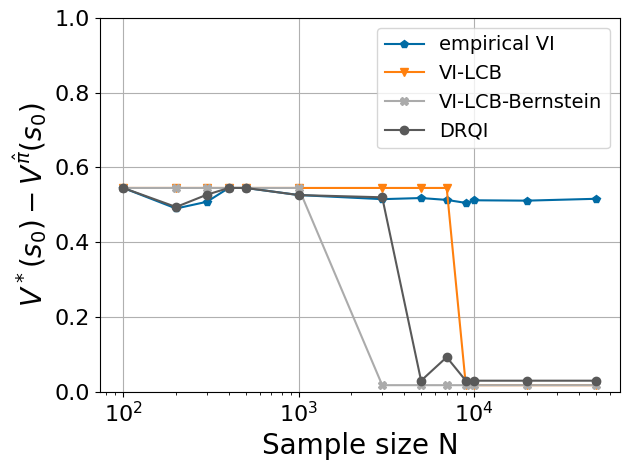

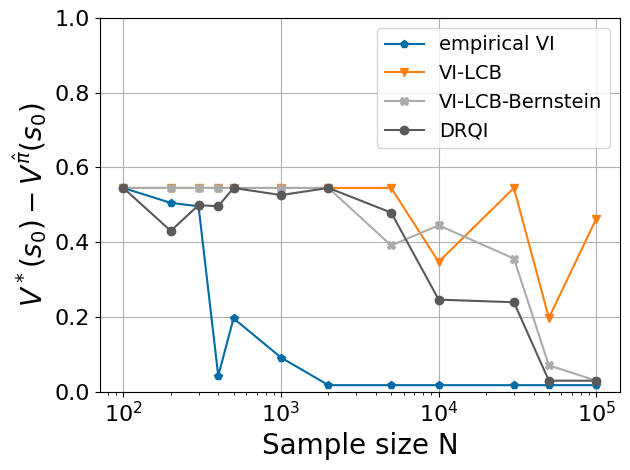

In [28]:
# plot
markercycler = cycle(markers)
colorcycler = cycle(colors)
bandcycler = cycle(bands)
fig_partial, ax_partial = plt.subplots(1, 1)

labels = ['empirical VI', 'VI-LCB', 'VI-LCB-Bernstein', 'DRQI']
sub_opt_partial = [sub_opt_evi_ls_partial, sub_opt_lcb_ls_partial, sub_opt_lcb_bern_ls_partial, sub_opt_drqi_ls_partial]
for i in range(len(labels)):
    ax_partial.plot(n_ls_partial, sub_opt_partial[i], marker=next(markercycler), color=next(colorcycler), label=labels[i],
                    linewidth=1.5, markersize=6)

ax_partial.legend(fontsize=14)
ax_partial.grid(visible=True)
ax_partial.set_ylabel(r"$V^*(s_0) - V^{\hat{\pi}}(s_0)$", fontsize=20)
ax_partial.set_xlabel("Sample size N", fontsize=20)
ax_partial.set_ylim([0, 1])
ax_partial.set_xscale('log')
ax_partial.tick_params(axis='both', which='both', labelsize=16)

fig_partial.tight_layout()

markercycler = cycle(markers)
colorcycler = cycle(colors)
bandcycler = cycle(bands)
fig_full, ax_full = plt.subplots(1, 1)

labels = ['empirical VI', 'VI-LCB', 'VI-LCB-Bernstein', 'DRQI']
sub_opt_full = [sub_opt_evi_ls_full, sub_opt_lcb_ls_full, sub_opt_lcb_bern_ls_full, sub_opt_drqi_ls_full]
for i in range(len(labels)):
    ax_full.plot(n_ls_full, sub_opt_full[i], marker=next(markercycler), color=next(colorcycler), label=labels[i],
                 linewidth=1.5, markersize=6)

ax_full.legend(fontsize=14)
ax_full.grid(visible=True)
ax_full.set_ylabel(r"$V^*(s_0) - V^{\hat{\pi}}(s_0)$", fontsize=20)
ax_full.set_xlabel("Sample size N", fontsize=20)
ax_full.set_ylim([0, 1])
ax_full.set_xscale('log')
ax_full.tick_params(axis='both', which='both', labelsize=16)

fig_full.tight_layout()